In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
btc = pd.read_csv("../BTC_data.csv", parse_dates=["date"], index_col="date")
print("Shape:", btc.shape)
print("\nColumns:", btc.columns.tolist())
print("\nDate range:", btc.index.min().date(), "→", btc.index.max().date())
print("\nMissing values (top 10):")
print(btc.isna().mean().sort_values(ascending=False).head(10))


Shape: (3177, 49)

Columns: ['open', 'high', 'low', 'close', 'volume', 'log_price', 'log_ret', 'ret_5d', 'ret_20d', 'vol_20d', 'mom_10d', 'sma10', 'sma20', 'sma50', 'SP500', 'SP500_log_price', 'SP500_lret', 'SP500_ret_5d', 'SP500_ret_20d', 'SP500_vol_20d', 'SP500_mom_10d', 'SP500_sma10', 'SP500_sma20', 'SP500_sma50', 'GOLD', 'GOLD_log_price', 'GOLD_lret', 'GOLD_ret_5d', 'GOLD_ret_20d', 'GOLD_vol_20d', 'GOLD_mom_10d', 'GOLD_sma10', 'GOLD_sma20', 'GOLD_sma50', 'DXY', 'DXY_log_price', 'DXY_lret', 'DXY_ret_5d', 'DXY_ret_20d', 'DXY_vol_20d', 'DXY_mom_10d', 'DXY_sma10', 'DXY_sma20', 'DXY_sma50', 'ret_1d_arith', 'y_price_next', 'y_log_price_next', 'y_ret_1d_next', 'y_log_ret_1d_next']

Date range: 2017-03-15 → 2025-11-24

Missing values (top 10):
open              0.0
GOLD_log_price    0.0
GOLD_ret_5d       0.0
GOLD_ret_20d      0.0
GOLD_vol_20d      0.0
GOLD_mom_10d      0.0
GOLD_sma10        0.0
GOLD_sma20        0.0
GOLD_sma50        0.0
DXY               0.0
dtype: float64


<Figure size 2000x1800 with 0 Axes>

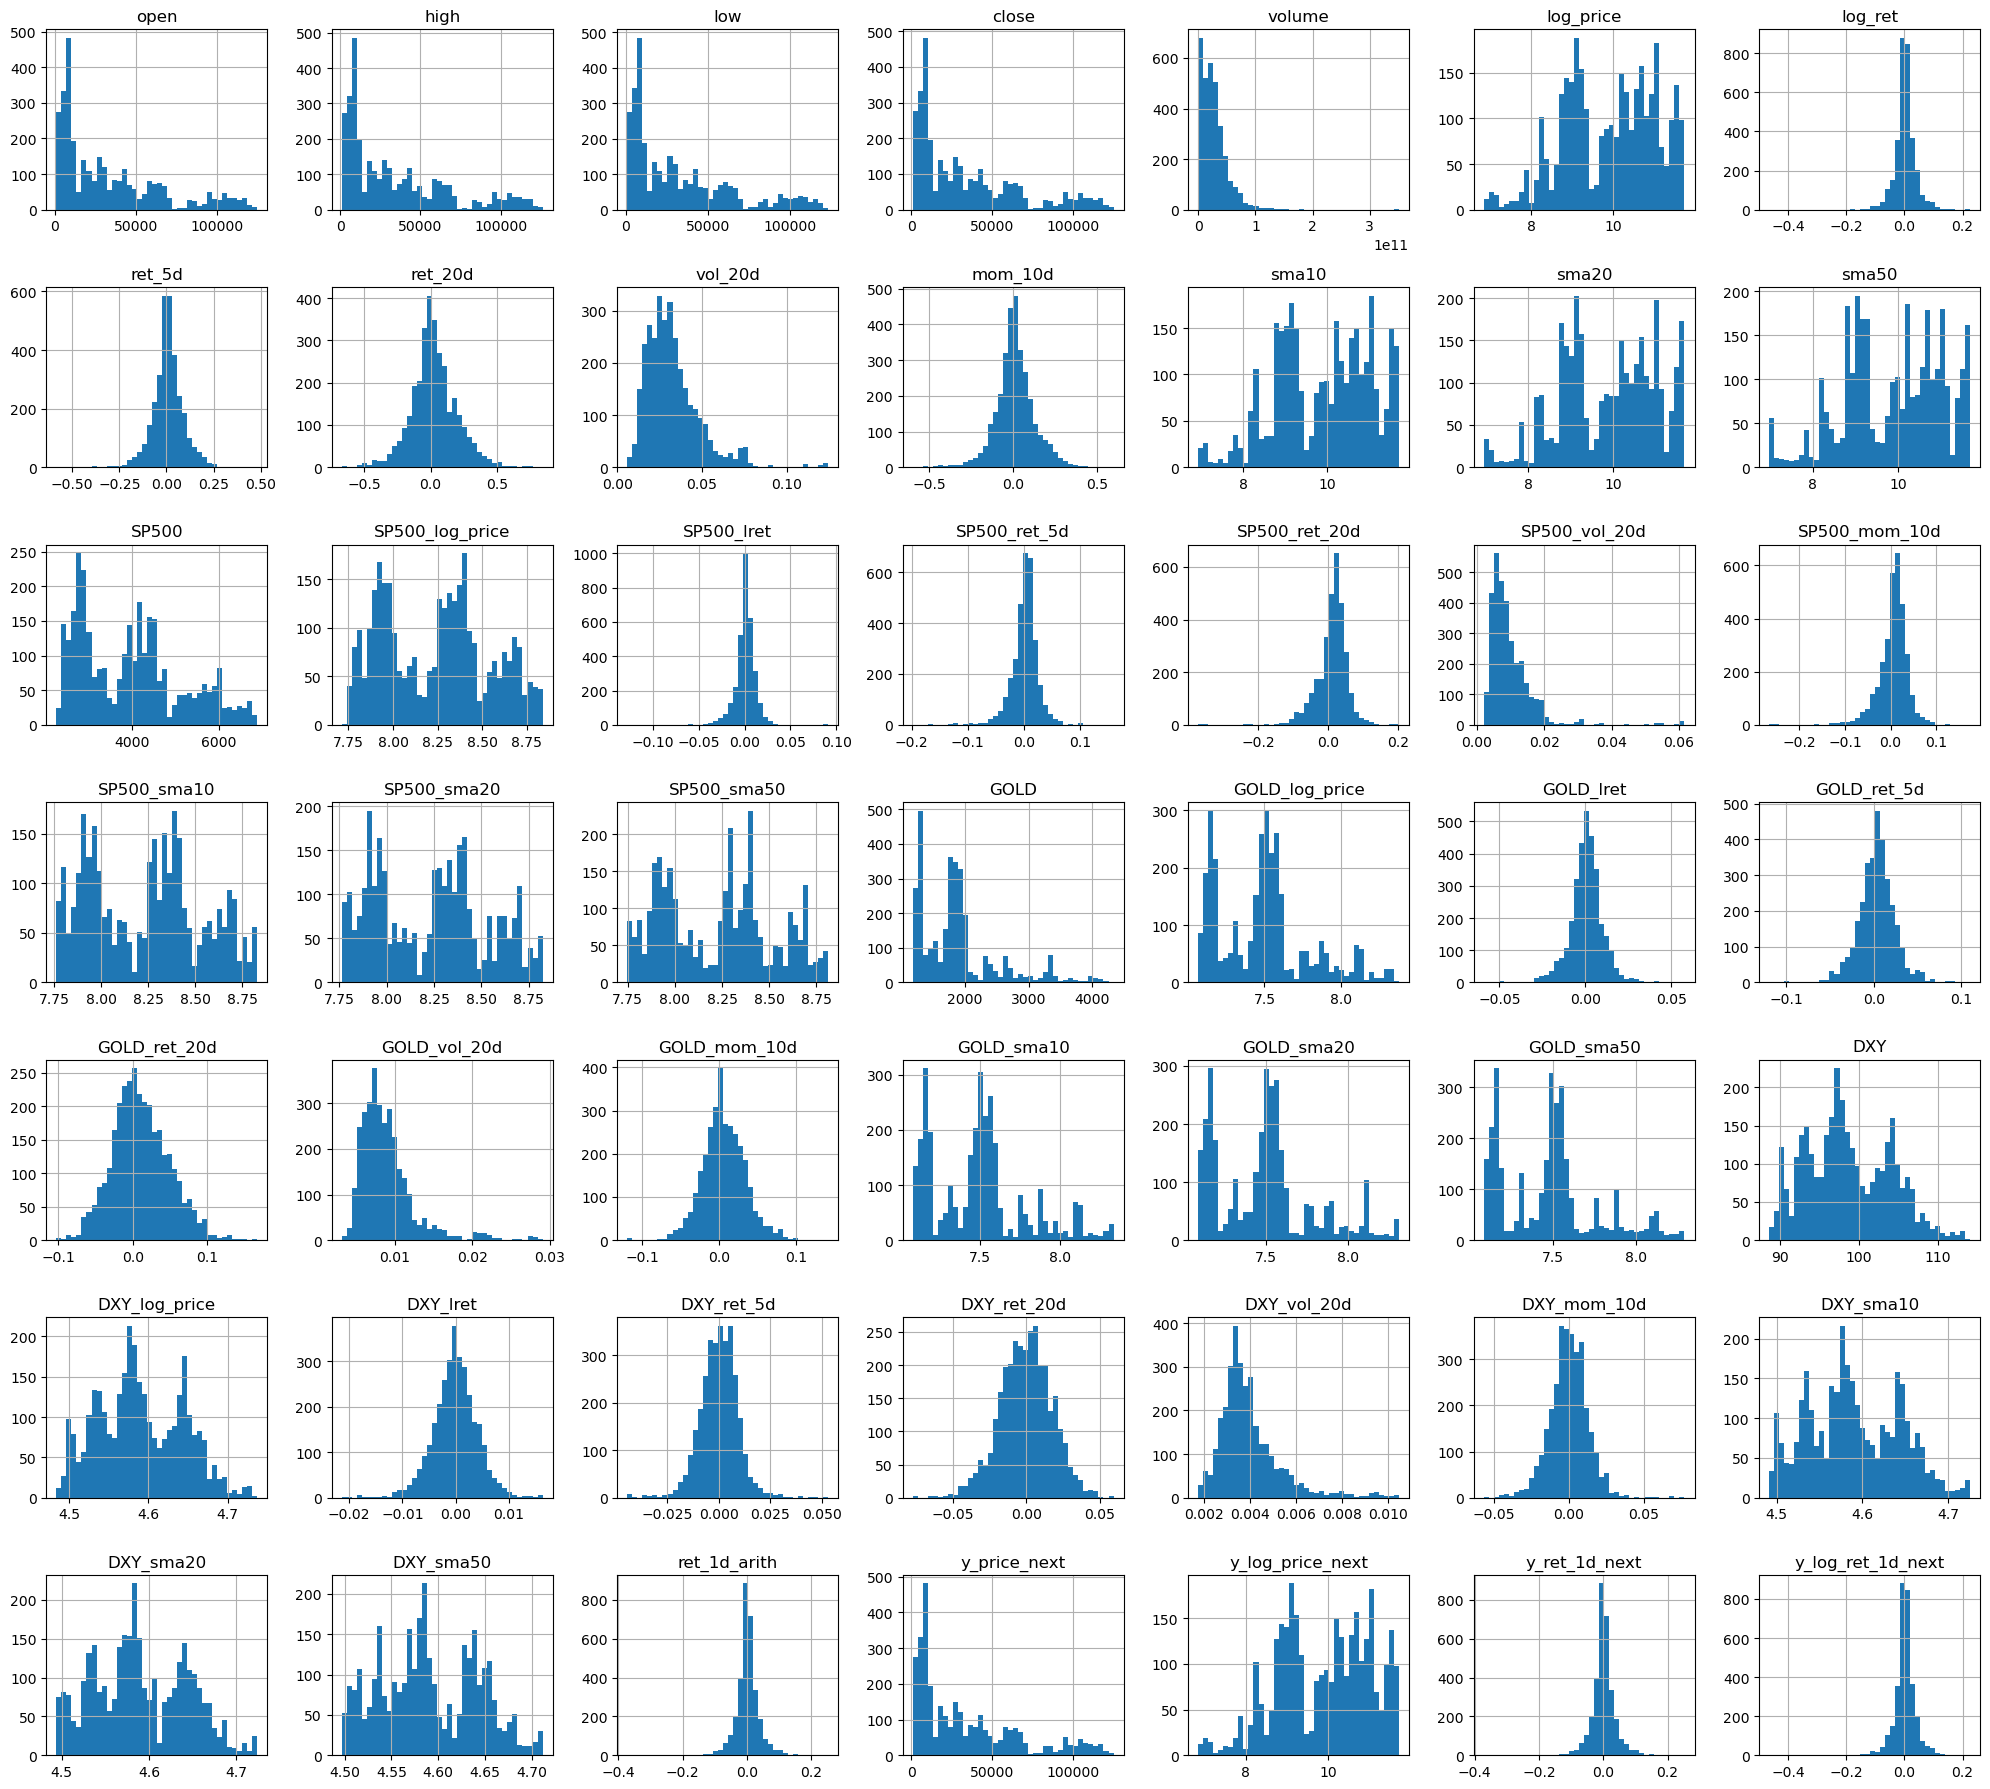

In [4]:
plt.figure(figsize=(20, 18))
btc.hist(figsize=(20, 18), bins=40)
plt.tight_layout()
plt.show()

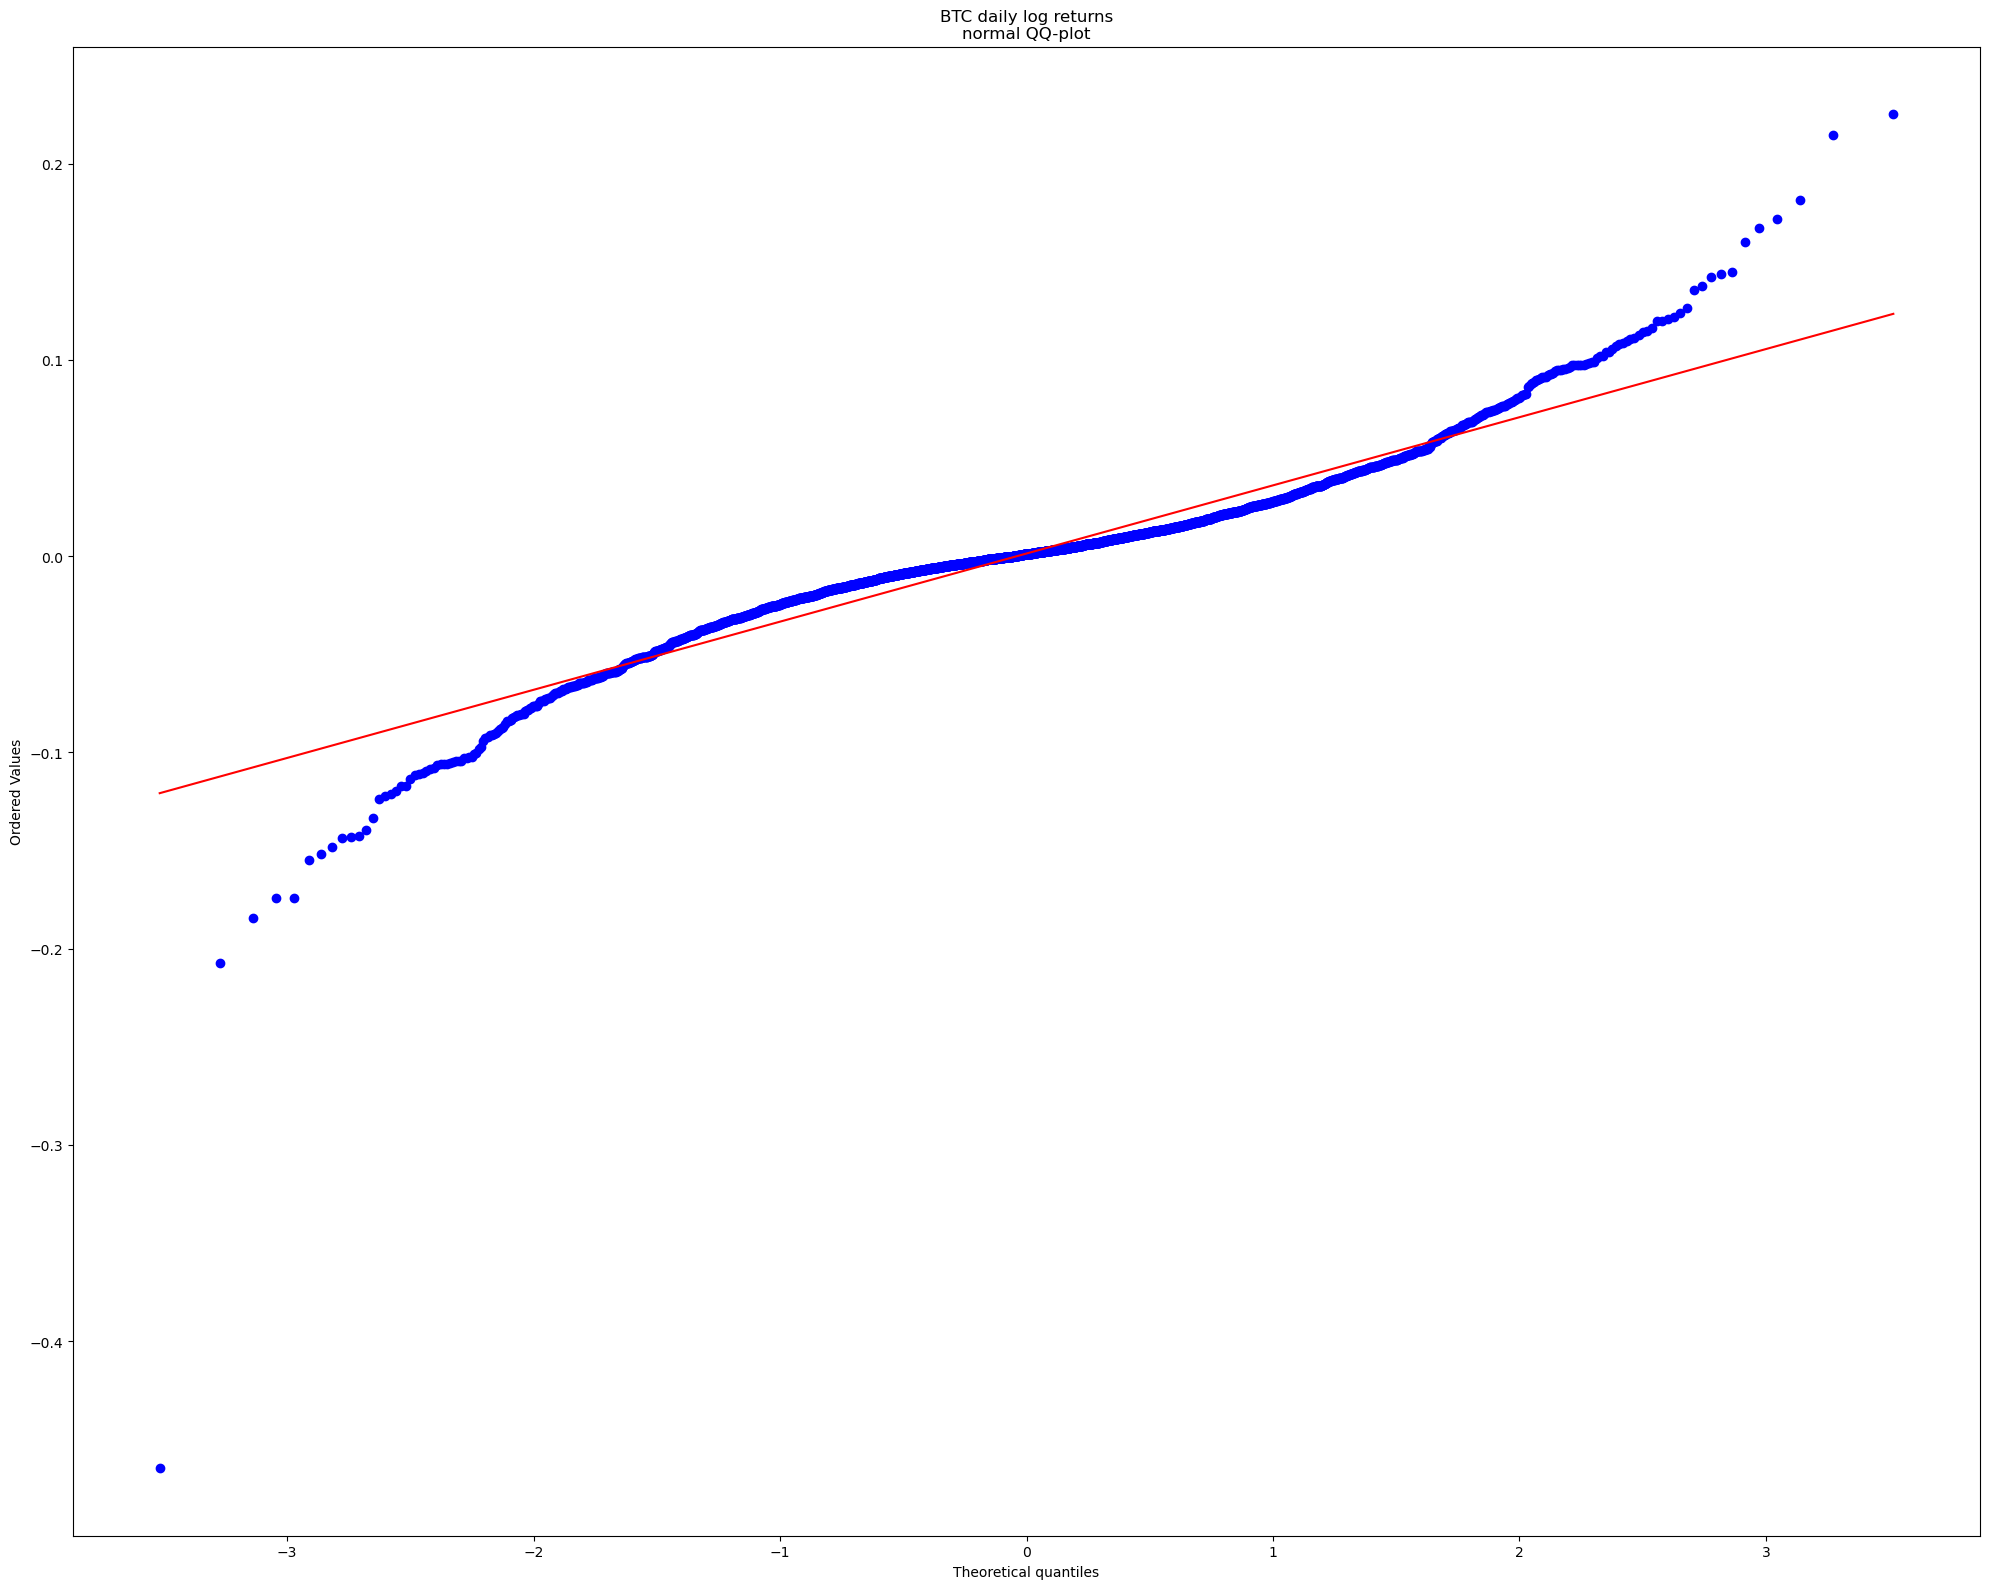

12.049055145053316

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 选择 BTC 日 log return

plt.figure(figsize=(20, 16))
stats.probplot(btc["log_ret"], dist="norm", plot=plt)
plt.title("BTC daily log returns\nnormal QQ-plot")
plt.tight_layout()
plt.show()

btc["log_ret"].kurtosis()

In [20]:
btc["vol_20d"].skew()

1.7134973083497578

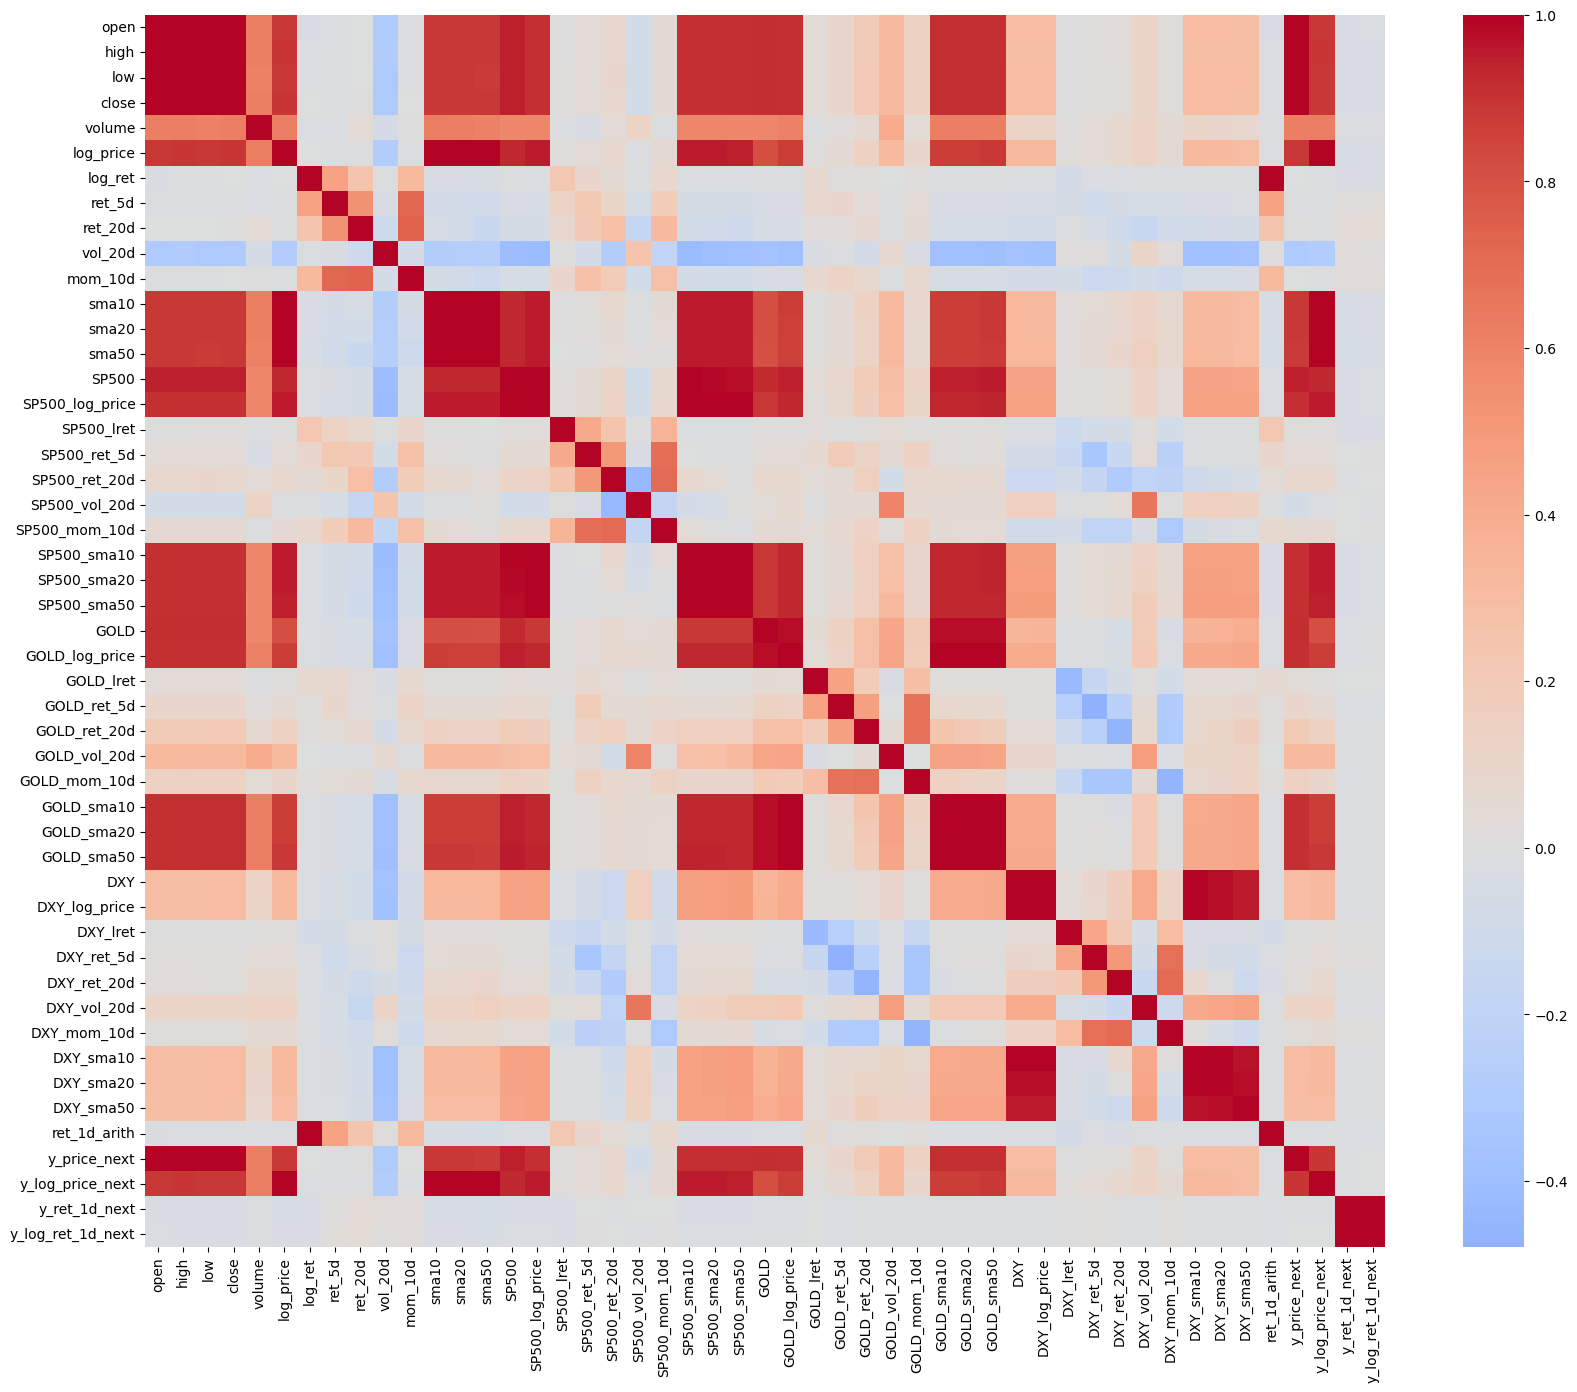

In [6]:
plt.figure(figsize=(20, 16))
sns.heatmap(btc.corr(), cmap="coolwarm", center=0)
plt.show()


In [7]:
target_cols = [
    "y_price_next",
    "y_log_price_next",
    "y_ret_1d_next",
    "y_log_ret_1d_next"
]

corr = btc.corr()

for target in target_cols:
    print(f"\n===== Correlation with {target} =====")

    corr_to_y = corr[target].drop(target).sort_values()

    print("\nTop negative correlations:")
    print(corr_to_y.head(10))

    print("\nTop positive correlations:")
    print(corr_to_y.tail(10))




===== Correlation with y_price_next =====

Top negative correlations:
vol_20d             -0.298394
SP500_vol_20d       -0.073481
ret_1d_arith        -0.008210
y_ret_1d_next       -0.007454
ret_5d              -0.005514
mom_10d             -0.004259
log_ret             -0.002670
y_log_ret_1d_next   -0.001875
DXY_lret             0.001583
ret_20d              0.002154
Name: y_price_next, dtype: float64

Top positive correlations:
GOLD_sma20         0.908157
SP500_sma10        0.908432
SP500_log_price    0.909175
GOLD_sma50         0.910804
GOLD               0.915018
SP500              0.943840
open               0.998532
low                0.998874
high               0.998929
close              0.999235
Name: y_price_next, dtype: float64

===== Correlation with y_log_price_next =====

Top negative correlations:
vol_20d             -0.277289
SP500_vol_20d       -0.017138
mom_10d             -0.012538
ret_5d              -0.012347
ret_1d_arith        -0.011510
y_ret_1d_next       -0.010

In [8]:
from xgboost import XGBRegressor

target_cols = [
    "y_price_next",
    "y_log_price_next",
    "y_ret_1d_next",
    "y_log_ret_1d_next",
]

# features are all non-target columns
X = btc.drop(columns=target_cols)

for target in target_cols:
    y = btc[target]

    print(f"\n===== XGBoost feature importance for {target} =====")

    model = XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
    )

    model.fit(X, y)

    importances = pd.Series(model.feature_importances_, index=X.columns)
    print("\nTop 15 features:")
    print(importances.sort_values(ascending=False).head(15))


===== XGBoost feature importance for y_price_next =====

Top 15 features:
log_price         0.418108
close             0.320182
low               0.083882
high              0.068513
GOLD_sma50        0.060198
sma10             0.022380
open              0.014565
sma20             0.005599
DXY_sma20         0.001709
GOLD_log_price    0.000750
SP500_sma10       0.000494
DXY               0.000301
GOLD_sma20        0.000279
GOLD              0.000219
SP500_sma50       0.000170
dtype: float32

===== XGBoost feature importance for y_log_price_next =====

Top 15 features:
log_price      0.303328
close          0.248948
low            0.192132
high           0.062651
SP500_sma10    0.056591
sma10          0.053901
SP500_sma20    0.036983
SP500_sma50    0.015087
GOLD_sma50     0.008151
open           0.008107
DXY_sma10      0.006379
sma20          0.003227
DXY_sma20      0.002241
sma50          0.000366
DXY_sma50      0.000241
dtype: float32

===== XGBoost feature importance for y_ret_1d_next

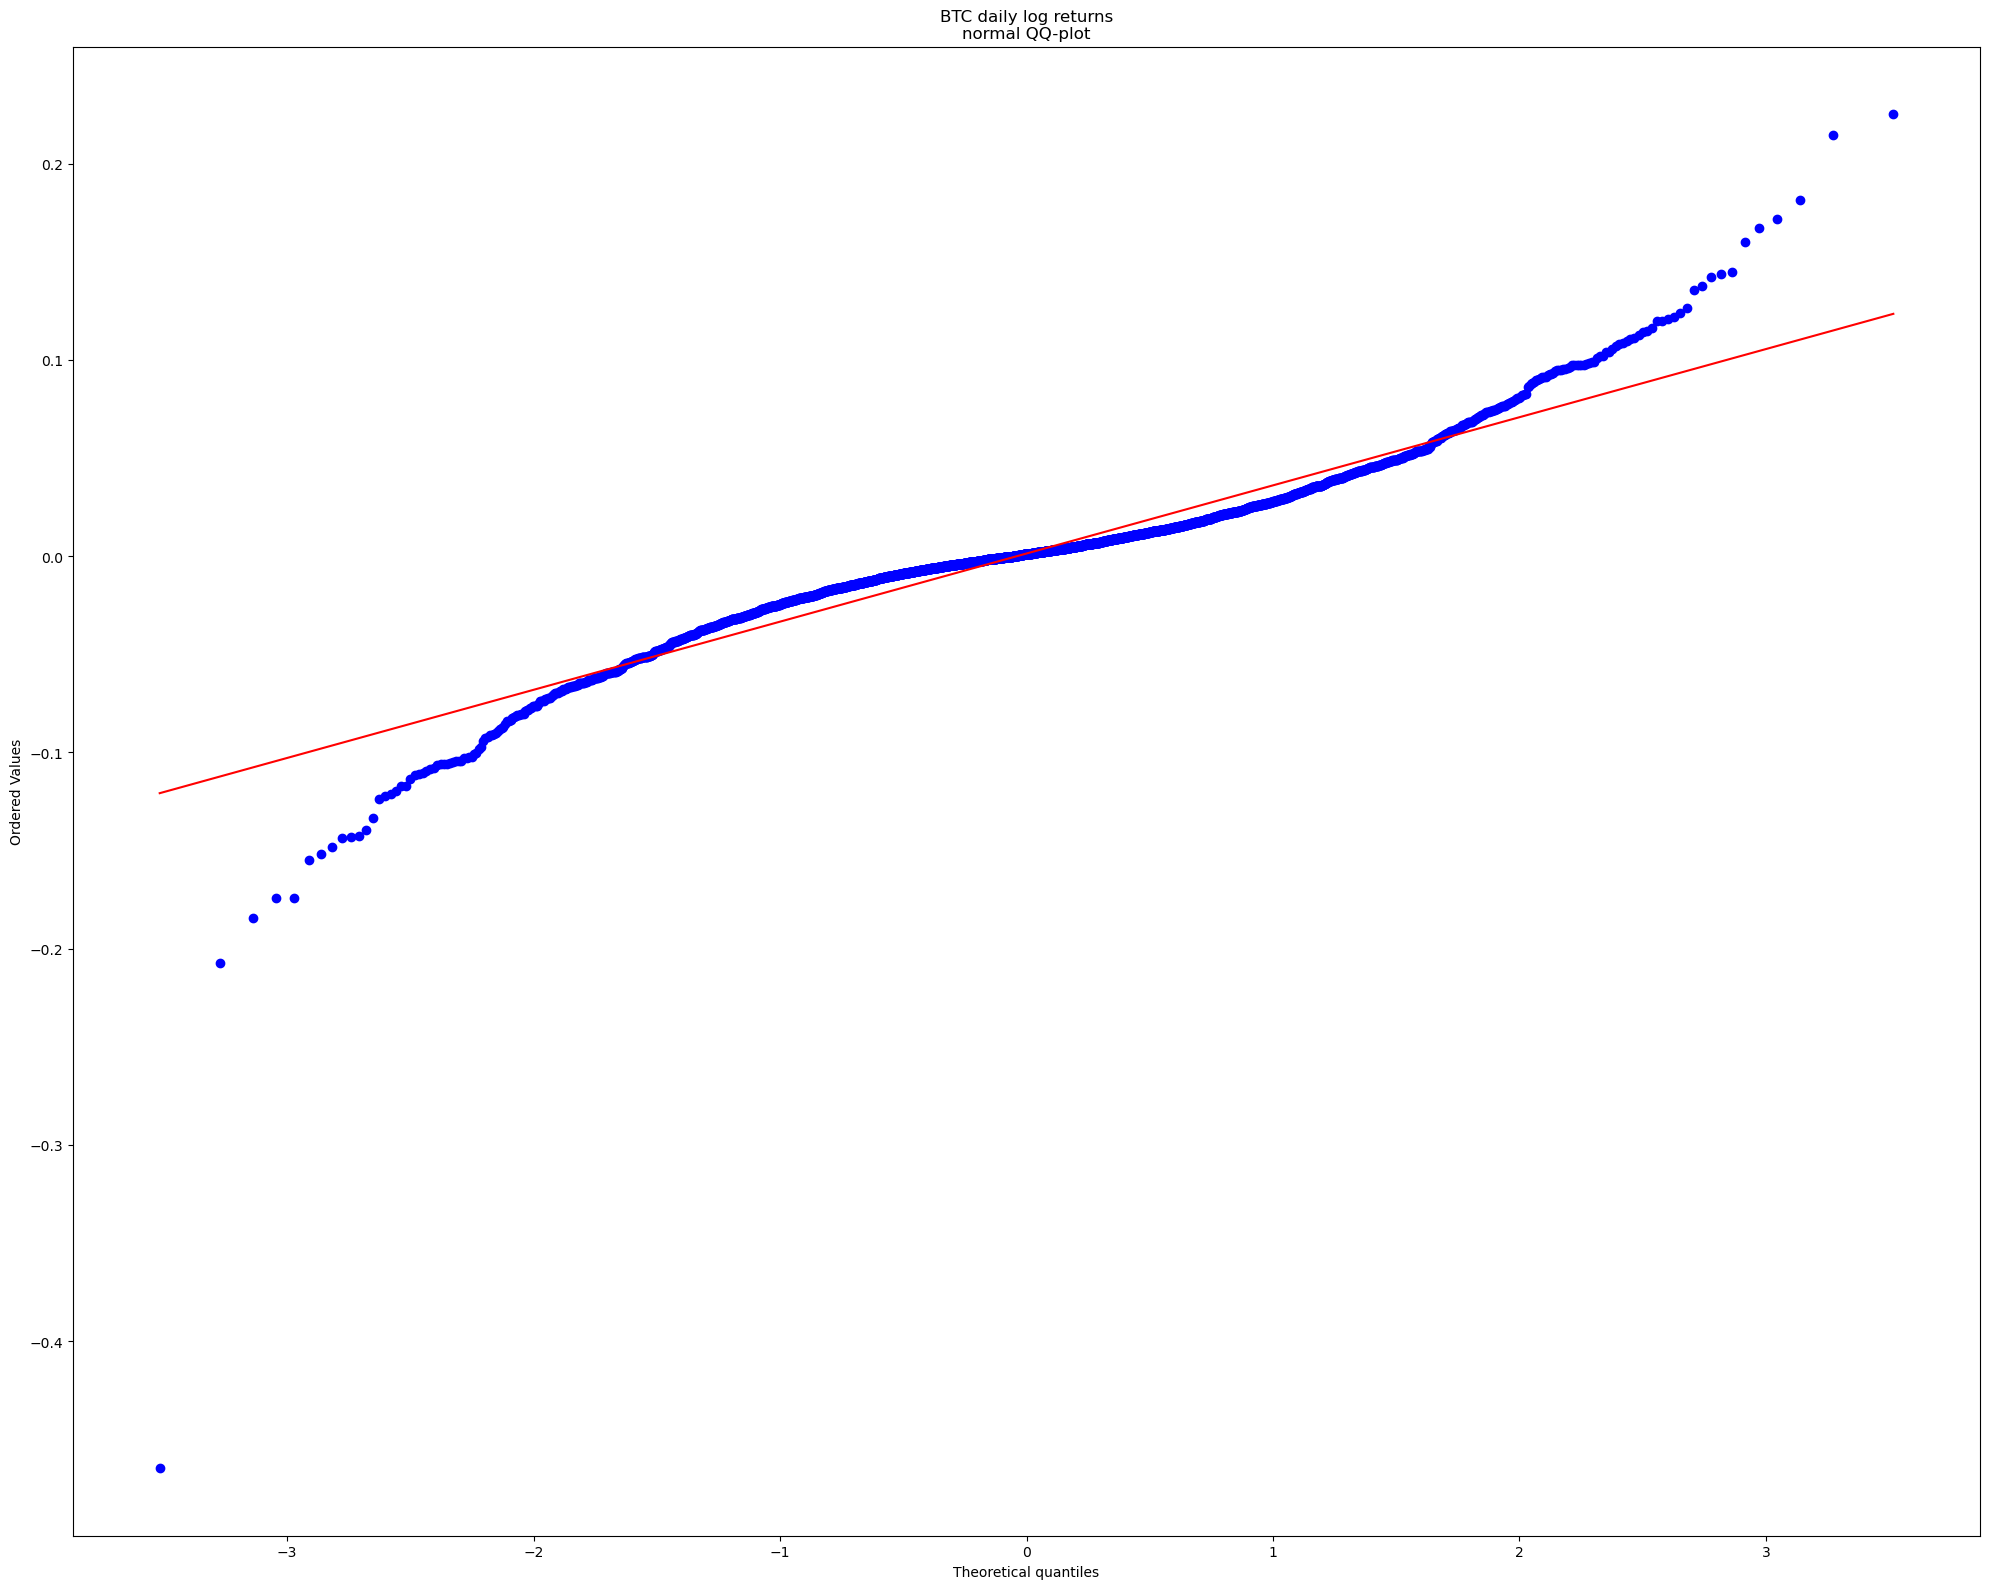

12.049055145053316

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 选择 BTC 日 log return

plt.figure(figsize=(20, 16))
stats.probplot(btc["log_ret"], dist="norm", plot=plt)
plt.title("BTC daily log returns\nnormal QQ-plot")
plt.tight_layout()
plt.show()

btc["log_ret"].kurtosis()

In [9]:


regimes = {
    "2017-2019": ("2017-01-01", "2019-12-31"),
    "2020-2021": ("2020-01-01", "2021-12-31"),
    "2022-2025": ("2022-01-01", btc.index.max().strftime("%Y-%m-%d")),
}

print("Regime summary:")
for name, (start, end) in regimes.items():
    sub = btc.loc[start:end]
    print(f"- {name}: {start} -> {end}, rows = {len(sub)}")


Regime summary:
- 2017-2019: 2017-01-01 -> 2019-12-31, rows = 1022
- 2020-2021: 2020-01-01 -> 2021-12-31, rows = 731
- 2022-2025: 2022-01-01 -> 2025-11-24, rows = 1424


In [10]:
def corr_in_regime(df, target, start, end, top=10):
    sub = df.loc[start:end]
    corr = sub.corr()[target].drop(target).sort_values()
    
    return corr.head(top), corr.tail(top)


In [11]:
target = "y_log_price_next"

for name, (start, end) in regimes.items():
    print(f"\n===== Correlation with {target} in {name} =====")

    neg, pos = corr_in_regime(btc, target, start, end, top=10)

    print("\nTop negative correlations:")
    print(neg)

    print("\nTop positive correlations:")
    print(pos)



===== Correlation with y_log_price_next in 2017-2019 =====

Top negative correlations:
DXY_sma50       -0.499772
DXY_sma20       -0.444787
DXY_sma10       -0.417523
DXY             -0.394141
DXY_log_price   -0.391622
DXY_vol_20d     -0.284804
GOLD_lret       -0.015100
ret_5d          -0.014012
mom_10d         -0.009208
log_ret         -0.007000
Name: y_log_price_next, dtype: float64

Top positive correlations:
SP500_sma20     0.690199
high            0.921681
open            0.924327
close           0.928082
y_price_next    0.931695
low             0.933626
sma50           0.944158
sma20           0.978653
sma10           0.989344
log_price       0.997409
Name: y_log_price_next, dtype: float64

===== Correlation with y_log_price_next in 2020-2021 =====

Top negative correlations:
DXY_sma50       -0.804931
DXY_sma20       -0.708927
DXY_sma10       -0.673133
DXY             -0.647366
DXY_log_price   -0.645813
SP500_vol_20d   -0.529128
GOLD_vol_20d    -0.400911
DXY_vol_20d     -0.391801


In [12]:
primary_target = "y_log_ret_1d_next"

for name, (start, end) in regimes.items():
    print(f"\n===== Correlation with {primary_target} in {name} =====")

    neg, pos = corr_in_regime(btc, primary_target, start, end, top=10)

    print("\nTop negative correlations:")
    print(neg)

    print("\nTop positive correlations:")
    print(pos)



===== Correlation with y_log_ret_1d_next in 2017-2019 =====

Top negative correlations:
low           -0.092700
open          -0.090743
close         -0.088888
sma50         -0.088715
high          -0.088399
sma20         -0.085874
sma10         -0.081866
log_price     -0.078813
SP500_sma50   -0.071577
SP500_sma10   -0.066584
Name: y_log_ret_1d_next, dtype: float64

Top positive correlations:
DXY_sma10        0.013475
DXY              0.016094
DXY_ret_5d       0.016140
DXY_log_price    0.016611
DXY_sma20        0.019285
ret_5d           0.026453
DXY_sma50        0.029246
mom_10d          0.046853
ret_20d          0.070952
y_ret_1d_next    0.998724
Name: y_log_ret_1d_next, dtype: float64

===== Correlation with y_log_ret_1d_next in 2020-2021 =====

Top negative correlations:
log_ret        -0.087997
ret_1d_arith   -0.080483
GOLD_ret_5d    -0.067549
GOLD_ret_20d   -0.055727
low            -0.054640
close          -0.054061
high           -0.052180
open           -0.050970
SP500_lret    

In [13]:
# protential signal：mom_10d，ret_20d, vol_20d, SP500_ret_5d, DXY_lret

signal = btc["mom_10d"]
future_ret = btc["y_log_ret_1d_next"]

data = pd.DataFrame({"signal": signal, "future_ret": future_ret})

data["bucket"] = pd.qcut(data["signal"], 5, labels=False)

bucket_mean = data.groupby("bucket")["future_ret"].mean()
bucket_hit  = data.groupby("bucket")["future_ret"].apply(lambda x: (x > 0).mean())

print("Average next-day log return by momentum bucket:")
print(bucket_mean)

print("\nHit rate (P(future_ret > 0)) by bucket:")
print(bucket_hit)


Average next-day log return by momentum bucket:
bucket
0   -0.000908
1    0.000552
2    0.000622
3    0.001030
4    0.005385
Name: future_ret, dtype: float64

Hit rate (P(future_ret > 0)) by bucket:
bucket
0    0.520440
1    0.525984
2    0.497638
3    0.497638
4    0.553459
Name: future_ret, dtype: float64


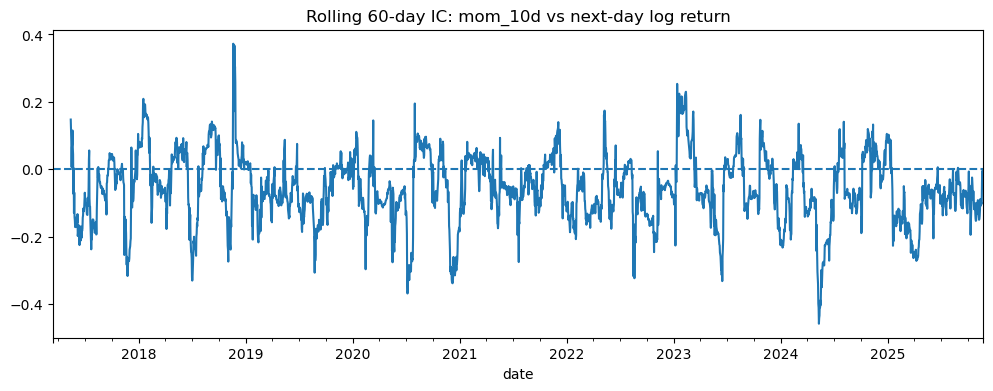

IC summary:
count    3118.000000
mean       -0.059245
std         0.100928
min        -0.458942
25%        -0.116552
50%        -0.063862
75%         0.010254
max         0.372482
Name: (mom_10d, y_log_ret_1d_next), dtype: float64


In [14]:
window = 60 

ic_series = (
    btc[["mom_10d", "y_log_ret_1d_next"]]
    .dropna()
    .rolling(window)
    .corr()
    .unstack()
    .iloc[:, 1]  
)

ic_series.plot(figsize=(12, 4))
plt.axhline(0, linestyle="--")
plt.title(f"Rolling {window}-day IC: mom_10d vs next-day log return")
plt.show()

print("IC summary:")
print(ic_series.describe())


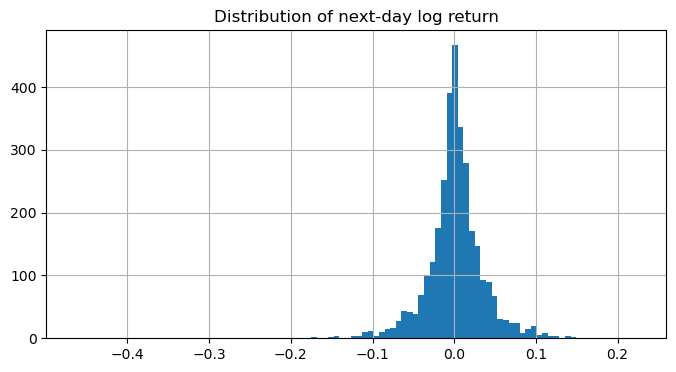

count    3177.000000
mean        0.001337
std         0.036370
min        -0.464730
25%        -0.013840
50%         0.001006
75%         0.016877
max         0.225119
Name: y_log_ret_1d_next, dtype: float64


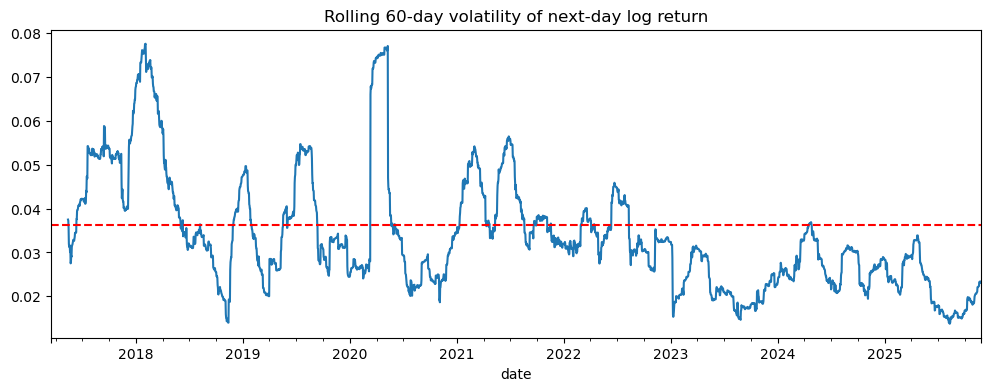

In [15]:
# distribution (hist)
btc["y_log_ret_1d_next"].hist(bins=100, figsize=(8,4))
plt.title("Distribution of next-day log return")
plt.show()

# summary stats
print(btc["y_log_ret_1d_next"].describe())

# rolling volatility
btc["y_log_ret_1d_next"].rolling(60).std().plot(figsize=(12,4))
plt.title("Rolling 60-day volatility of next-day log return")
plt.axhline(btc["y_log_ret_1d_next"].std(), color="red", linestyle="--")
plt.show()
